In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

DATA_PATH = "big_dataset_lfw"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5

# Recharger les datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.2, subset="training", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.2, subset="validation", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Reconstruire l'architecture exacte
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
])

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Charger les poids
model.load_weights("mobilenetv2_weights.weights.h5")

# Réveiller le modèle
dummy = tf.zeros((1, 224, 224, 3))
_ = model(dummy)

print(f" Modèle chargé — Classes : {class_names}")

Found 2000 files belonging to 5 classes.
Using 1600 files for training.
Found 2000 files belonging to 5 classes.
Using 400 files for validation.



C:\Users\marwa\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Modèle chargé — Classes : ['01_02', '03_04', '05_06', '07_08', '09_10']


In [ ]:
def extract_features(images):
    """Extrait les embeddings 1280-dim via base_model."""
    x = preprocess_input(tf.identity(images))
    x = base_model(x, training=False)
    x = tf.reduce_max(x, axis=[1, 2])  # GlobalMaxPooling2D manuel
    return x

# Test rapide
test_emb = extract_features(tf.zeros((1, 224, 224, 3)))
print(f" Feature extractor OK — Shape : {test_emb.shape}")  # (1, 1280)


def extract_attack_signals(image_paths, target_model):
    """Extrait embeddings, confiance et entropie pour chaque image."""
    embeddings = []
    confidence_vectors = []
    entropies = []
    
    for i, path in enumerate(image_paths):
        if i % 50 == 0:
            print(f"  → {i}/{len(image_paths)}...")
        
        img = tf.keras.utils.load_img(path, target_size=(224, 224))
        img_array = tf.expand_dims(tf.keras.utils.img_to_array(img), 0)
        
        # Embedding 1280-dim
        emb = extract_features(img_array)
        embeddings.append(emb.numpy().flatten())
        
        # Vecteur de confiance softmax (5-dim)
        conf = target_model.predict(img_array, verbose=0)
        confidence_vectors.append(conf.flatten())
        
        # Entropie (basse = modèle très sûr = potentiel mémorisation)
        ent = entropy(conf.flatten())
        entropies.append(ent)
    
    print(f"  → {len(image_paths)}/{len(image_paths)} ✓")
    return {
        'embeddings': np.array(embeddings),
        'confidences': np.array(confidence_vectors),
        'entropies': np.array(entropies)
    }

print(" Fonctions définies")

✅ Feature extractor OK — Shape : (1, 1280)
✅ Fonctions définies


In [ ]:
all_paths = sorted(glob.glob(os.path.join(DATA_PATH, "**", "*.png"), recursive=True))
print(f"Total images trouvées : {len(all_paths)}")

# Reproduire le split train/val (seed=123, 80/20)
np.random.seed(123)
indices = np.random.permutation(len(all_paths))
split_idx = int(0.8 * len(all_paths))

train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

member_paths = [all_paths[i] for i in train_indices]
nonmember_paths = [all_paths[i] for i in val_indices]

# Sous-échantillonner (max 200 chaque pour la vitesse)
MAX_SAMPLES = 200
if len(member_paths) > MAX_SAMPLES:
    member_paths = random.sample(member_paths, MAX_SAMPLES)
if len(nonmember_paths) > MAX_SAMPLES:
    nonmember_paths = random.sample(nonmember_paths, MAX_SAMPLES)

print(f"Membres (train set)     : {len(member_paths)} images")
print(f"Non-membres (val set)   : {len(nonmember_paths)} images")

# Extraction des signaux
print("\nExtraction des signaux pour les MEMBRES...")
member_signals = extract_attack_signals(member_paths, model)

print("\nExtraction des signaux pour les NON-MEMBRES...")
nonmember_signals = extract_attack_signals(nonmember_paths, model)

print(f"\n Terminé !")
print(f"   Embeddings membres     : {member_signals['embeddings'].shape}")
print(f"   Embeddings non-membres : {nonmember_signals['embeddings'].shape}")

Total images trouvées : 2000
Membres (train set)     : 200 images
Non-membres (val set)   : 200 images

Extraction des signaux pour les MEMBRES...
  → 0/200...
  → 50/200...
  → 100/200...
  → 150/200...
  → 200/200 ✓

Extraction des signaux pour les NON-MEMBRES...
  → 0/200...
  → 50/200...
  → 100/200...
  → 150/200...
  → 200/200 ✓

✅ Terminé !
   Embeddings membres     : (200, 1280)
   Embeddings non-membres : (200, 1280)


In [ ]:
# Split 50/50 avec une seed DIFFÉRENTE pour le shadow
shadow_train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.5, subset="training", seed=42,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)
shadow_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.5, subset="validation", seed=42,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)

shadow_train_ds = shadow_train_ds.cache().shuffle(500).prefetch(tf.data.AUTOTUNE)
shadow_test_ds = shadow_test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Architecture identique au modèle cible
shadow_base = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
shadow_base.trainable = False

shadow_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),
    shadow_base,
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

shadow_model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

print(">>> Entraînement du Shadow Model...")
shadow_model.fit(shadow_train_ds, validation_data=shadow_test_ds, epochs=10, verbose=1)
print(" Shadow Model entraîné")

Found 2000 files belonging to 5 classes.
Using 1000 files for training.
Found 2000 files belonging to 5 classes.
Using 1000 files for validation.
>>> Entraînement du Shadow Model...
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.2240 - loss: 6.6508 - val_accuracy: 0.4140 - val_loss: 2.2465
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3130 - loss: 5.1741 - val_accuracy: 0.5060 - val_loss: 2.1015
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3860 - loss: 4.2509 - val_accuracy: 0.6510 - val_loss: 1.5035
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4600 - loss: 3.5825 - val_accuracy: 0.6780 - val_loss: 1.3812
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4870 - loss: 3.1663 - val_accuracy: 0.7270 - val_loss: 1.3043
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5430 - loss: 2.9409 - val_accuracy: 0.7470 - val_loss: 1.2265
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 984ms/step - accurac

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# --- A. Récupérer les vecteurs de confiance du shadow model ---
def get_confidence_vectors(dataset, m):
    all_confs = []
    for imgs, _ in dataset:
        confs = m.predict(imgs, verbose=0)
        all_confs.append(confs)
    return np.vstack(all_confs)

shadow_in_confs = get_confidence_vectors(shadow_train_ds, shadow_model)   # "membres" du shadow
shadow_out_confs = get_confidence_vectors(shadow_test_ds, shadow_model)   # "non-membres" du shadow

# --- B. Construire le dataset d'attaque ---
X_attack = np.vstack([shadow_in_confs, shadow_out_confs])
y_attack = np.concatenate([
    np.ones(len(shadow_in_confs)),    # 1 = membre
    np.zeros(len(shadow_out_confs))   # 0 = non-membre
])

shuffle_idx = np.random.permutation(len(X_attack))
X_attack = X_attack[shuffle_idx]
y_attack = y_attack[shuffle_idx]

# --- C. Entraîner le classifieur d'attaque ---
attack_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=200,
    random_state=42,
    early_stopping=True
)

split = int(0.8 * len(X_attack))
attack_model.fit(X_attack[:split], y_attack[:split])

# Évaluation
y_pred_attack = attack_model.predict(X_attack[split:])
y_prob_attack = attack_model.predict_proba(X_attack[split:])[:, 1]

print(f"Attack Model Accuracy : {accuracy_score(y_attack[split:], y_pred_attack):.4f}")
print(f"Attack Model AUC-ROC  : {roc_auc_score(y_attack[split:], y_prob_attack):.4f}")

Attack Model Accuracy : 0.5200
Attack Model AUC-ROC  : 0.5260


In [ ]:
# Passer les membres et non-membres du modèle CIBLE dans l'attack model
target_member_confs = member_signals['confidences']
target_nonmember_confs = nonmember_signals['confidences']

member_scores = attack_model.predict_proba(target_member_confs)[:, 1]
nonmember_scores = attack_model.predict_proba(target_nonmember_confs)[:, 1]

print("=" * 60)
print("         RÉSULTATS DE L'ATTAQUE IMIA")
print("=" * 60)
print(f"  Score moyen MEMBRES     : {member_scores.mean():.4f}")
print(f"  Score moyen NON-MEMBRES : {nonmember_scores.mean():.4f}")
print(f"  Différence (Δ)          : {member_scores.mean() - nonmember_scores.mean():.4f}")
print("=" * 60)

if member_scores.mean() - nonmember_scores.mean() > 0.05:
    print("  FUITE DÉTECTÉE : Le modèle se comporte différemment")
    print("   sur les données d'entraînement vs données inconnues.")
else:
    print(" PAS DE FUITE SIGNIFICATIVE")

         RÉSULTATS DE L'ATTAQUE IMIA
  Score moyen MEMBRES     : 0.4937
  Score moyen NON-MEMBRES : 0.4942
  Différence (Δ)          : -0.0004
✅ PAS DE FUITE SIGNIFICATIVE


In [ ]:
# ============================================================
# BLOC 6 (OPTIMISÉ) : FEATURE LEAKAGE — SIMILARITÉ COSINUS
# Version batch pour éviter les crashes mémoire
# ============================================================
from sklearn.metrics.pairwise import cosine_similarity

# On utilise les embeddings déjà extraits au Bloc 2
# member_signals['embeddings'] = embeddings des images du train set (membres)
# nonmember_signals['embeddings'] = embeddings des images du val set (non-membres)

# Similarité cosinus entre membres et non-membres
# Chaque membre est comparé à tous les non-membres et vice versa
sim_matrix = cosine_similarity(member_signals['embeddings'], nonmember_signals['embeddings'])

# Pour chaque membre, sa similarité MAX avec un non-membre
max_sim_members = sim_matrix.max(axis=1)
# Pour chaque non-membre, sa similarité MAX avec un membre
max_sim_nonmembers = sim_matrix.max(axis=0)

# Similarité intra-groupe (membres entre eux vs non-membres entre eux)
sim_intra_members = cosine_similarity(member_signals['embeddings'])
sim_intra_nonmembers = cosine_similarity(nonmember_signals['embeddings'])

# Moyenne des similarités (en excluant la diagonale = self-similarity)
np.fill_diagonal(sim_intra_members, 0)
np.fill_diagonal(sim_intra_nonmembers, 0)

avg_sim_members = sim_intra_members.sum() / (len(sim_intra_members) * (len(sim_intra_members) - 1))
avg_sim_nonmembers = sim_intra_nonmembers.sum() / (len(sim_intra_nonmembers) * (len(sim_intra_nonmembers) - 1))

print("=" * 60)
print("     ANALYSE DU FEATURE LEAKAGE (Similarité Cosinus)")
print("=" * 60)
print(f"  Sim. intra-MEMBRES (entre eux)      : {avg_sim_members:.4f}")
print(f"  Sim. intra-NON-MEMBRES (entre eux)   : {avg_sim_nonmembers:.4f}")
print(f"  Sim. max MEMBRES → NON-MEMBRES       : {max_sim_members.mean():.4f}")
print(f"  Sim. max NON-MEMBRES → MEMBRES       : {max_sim_nonmembers.mean():.4f}")
print("=" * 60)

if avg_sim_members > avg_sim_nonmembers + 0.01:
    print("    Les membres sont plus cohérents dans l'espace latent")
    print("     → Le modèle a regroupé ses données d'entraînement")
else:
    print("   Pas de différence significative de cohérence")

     ANALYSE DU FEATURE LEAKAGE (Similarité Cosinus)
  Sim. intra-MEMBRES (entre eux)      : 0.7660
  Sim. intra-NON-MEMBRES (entre eux)   : 0.7711
  Sim. max MEMBRES → NON-MEMBRES       : 0.8684
  Sim. max NON-MEMBRES → MEMBRES       : 0.8683
  ✅ Pas de différence significative de cohérence


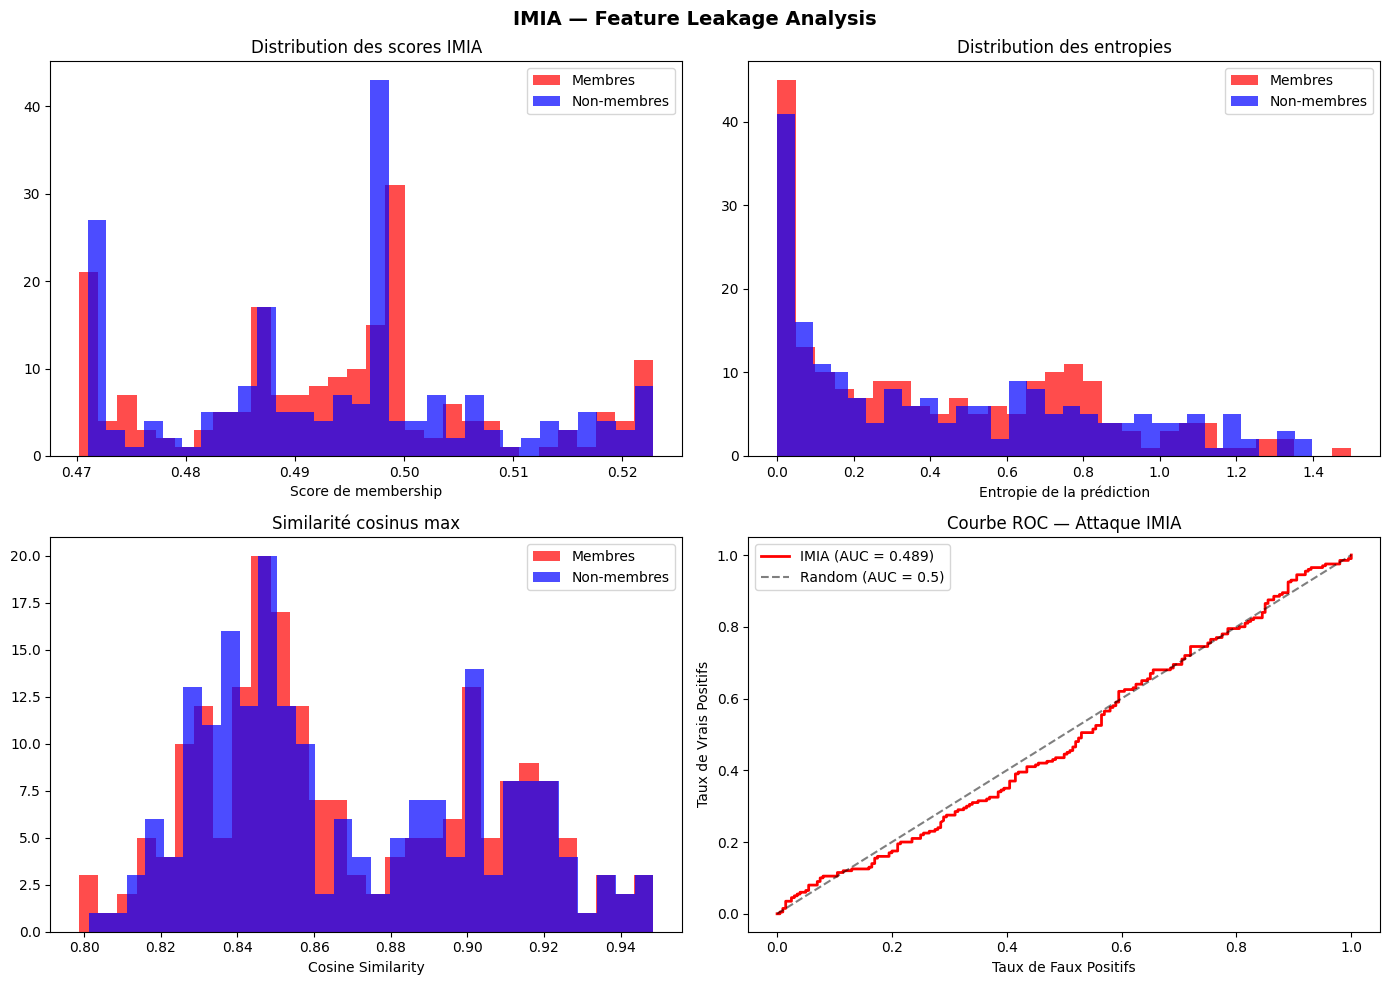

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A. Distribution des scores d'attaque
axes[0, 0].hist(member_scores, bins=30, alpha=0.7, label='Membres', color='red')
axes[0, 0].hist(nonmember_scores, bins=30, alpha=0.7, label='Non-membres', color='blue')
axes[0, 0].set_title('Distribution des scores IMIA')
axes[0, 0].set_xlabel('Score de membership')
axes[0, 0].legend()

# B. Distribution des entropies
axes[0, 1].hist(member_signals['entropies'], bins=30, alpha=0.7, label='Membres', color='red')
axes[0, 1].hist(nonmember_signals['entropies'], bins=30, alpha=0.7, label='Non-membres', color='blue')
axes[0, 1].set_title('Distribution des entropies')
axes[0, 1].set_xlabel('Entropie de la prédiction')
axes[0, 1].legend()

# C. Similarité cosinus
axes[1, 0].hist(max_sim_members, bins=30, alpha=0.7, label='Membres', color='red')
axes[1, 0].hist(max_sim_nonmembers, bins=30, alpha=0.7, label='Non-membres', color='blue')
axes[1, 0].set_title('Similarité cosinus max')
axes[1, 0].set_xlabel('Cosine Similarity')
axes[1, 0].legend()

# D. Courbe ROC
all_scores = np.concatenate([member_scores, nonmember_scores])
all_labels = np.concatenate([np.ones(len(member_scores)), np.zeros(len(nonmember_scores))])
fpr, tpr, _ = roc_curve(all_labels, all_scores)
auc_score = roc_auc_score(all_labels, all_scores)

axes[1, 1].plot(fpr, tpr, 'r-', linewidth=2, label=f'IMIA (AUC = {auc_score:.3f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.5)')
axes[1, 1].set_title('Courbe ROC — Attaque IMIA')
axes[1, 1].set_xlabel('Taux de Faux Positifs')
axes[1, 1].set_ylabel('Taux de Vrais Positifs')
axes[1, 1].legend()

plt.suptitle('IMIA — Feature Leakage Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
print("=" * 65)
print("        RAPPORT IMIA — ÉVALUATION DE LA CONFIDENTIALITÉ")
print("=" * 65)
print(f"  Modèle cible         : MobileNetV2 (fine-tuné)")
print(f"  Dataset              : {DATA_PATH} ({NUM_CLASSES} classes, {len(all_paths)} images)")
print(f"  Membres testés       : {len(member_paths)}")
print(f"  Non-membres testés   : {len(nonmember_paths)}")
print("-" * 65)
print(f"  AUC-ROC Attack Model (shadow)     : {roc_auc_score(y_attack[split:], y_prob_attack):.4f}")
print(f"  AUC-ROC IMIA (cible)              : {auc_score:.4f}")
print(f"  Δ score membership                : {member_scores.mean() - nonmember_scores.mean():.4f}")
print(f"  Δ similarité cosinus              : {max_sim_members.mean() - max_sim_nonmembers.mean():.4f}")
print(f"  Entropie moy. membres             : {member_signals['entropies'].mean():.4f}")
print(f"  Entropie moy. non-membres         : {nonmember_signals['entropies'].mean():.4f}")
print("-" * 65)

if auc_score > 0.7:
    print("    VERDICT : Fuite de features SIGNIFICATIVE détectée.")
    print("     Le morphing ne protège PAS suffisamment les identités sources.")
elif auc_score > 0.6:
    print("   VERDICT : Fuite MARGINALE détectée.")
    print("     Protection partielle, risque résiduel.")
else:
    print("   VERDICT : Pas de fuite significative.")
    print("     Le morphing protège efficacement les identités sources.")
print("=" * 65)

        RAPPORT IMIA — ÉVALUATION DE LA CONFIDENTIALITÉ
  Modèle cible         : MobileNetV2 (fine-tuné)
  Dataset              : big_dataset_lfw (5 classes, 2000 images)
  Membres testés       : 200
  Non-membres testés   : 200
-----------------------------------------------------------------
  AUC-ROC Attack Model (shadow)     : 0.5260
  AUC-ROC IMIA (cible)              : 0.4890
  Δ score membership                : -0.0004
  Δ similarité cosinus              : 0.0002
  Entropie moy. membres             : 0.4299
  Entropie moy. non-membres         : 0.4435
-----------------------------------------------------------------
  ✅ VERDICT : Pas de fuite significative.
     Le morphing protège efficacement les identités sources.
